In [187]:
# import sys
# sys.path.insert(1, '/path/to/application/app/folder')
import rotational_diffusion_photophysics as rdp
from os.path import dirname, join as pjoin
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import numpy as np

fit_index = '009'
sample_name = 'r_pw2_100nm'
mat_fname = './test_data/'+sample_name+'.mat'
mat_contents = sio.loadmat(mat_fname)

global t
global r
global il
global ip
global system

t = mat_contents['t'][:,0] * 1e-6 # [s]
r = mat_contents['r'][:,0]
il = mat_contents['il'][:,0]
ip = mat_contents['ip'][:,0]
tr = np.zeros((4, t.size))
norm =  np.max(il)
il = il / norm
ip = ip / norm

Text(0, 0.5, 'Intensity')

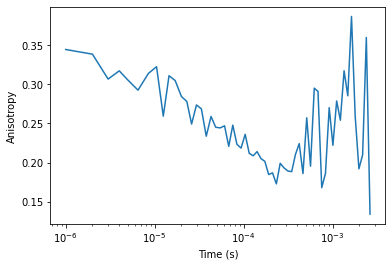

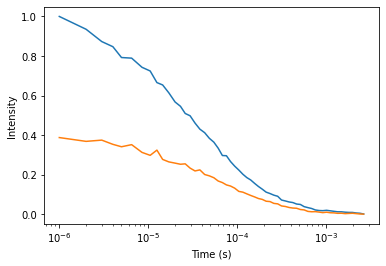

In [188]:
plt.figure()
plt.plot(t, r)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Anisotropy')

plt.figure()
plt.plot(t, il)
plt.plot(t, ip)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')

In [189]:
# Init empty experiment
lmax = 6
system = rdp.System(illumination=[],
                    fluorophore=[],
                    diffusion=[],
                    detection=[],
                    lmax=lmax)

def fitting_model(k, system=system, t=t, il=il, ip=ip):
    # Compute model ingredients and apply them to the system
    ingredients = model_ingredients(k)
    system.illumination = ingredients[0]
    system.detection = ingredients[1]
    system.fluorophore = ingredients[2]
    system.diffusion = ingredients[3]

    # Compute signals
    s = system.detector_signals(t) 
    s = s - s[:,-1][:,None]  # remove background
    r_theo = rdp.anisotropy(s)
    il_theo = s[0]
    ip_theo = s[1]

    # Find the best variable projection amplitude for il and ip
    A = var_proj_amplitude(il_theo, ip_theo, il, ip)
    il_theo = il_theo / A[0]
    ip_theo = ip_theo / A[0]
    return r_theo, il_theo, ip_theo


def model_ingredients(k):
    # k[0] - rotational diffusion time [s]

    # Objective parameters
    numerical_aperture = 1.105
    refractive_index = 1.518

    # Create the illumination scheme
    exc488X = rdp.ModulatedLasers(power_density=[2830*0.86*2.284], # 2830 pw2, 703 pw1
                                wavelength=[488],
                                polarization=['x'],
                                modulation=[[1]],
                                time_windows=[3e-3],
                                time0=0,
                                numerical_aperture=numerical_aperture,
                                refractive_index=refractive_index,
                                )

    # Create the detectors
    detXY = rdp.PolarizedDetection(polarization=['x', 'y'],
                                numerical_aperture=numerical_aperture,
                                refractive_index=refractive_index,
                                )

    # # Create the fluorophore, with the photophysics
    rsEGFP2 = rdp.NegativeSwitcher(extinction_coeff_on=[5260, 51560],
                                extinction_coeff_off=[22000, 60],
                                wavelength=[405, 488],
                                lifetime_on=1.6e-9,
                                quantum_yield_on_fluo=0.35,
                                quantum_yield_on_to_off=1.65e-2,
                                quantum_yield_off_to_on=0.33,
                                )

    rsEGFP2 = rdp.NegativeSwitcher(extinction_coeff_on= [  5260, 51560],
                                    extinction_coeff_off=[ 22000,    60],
                                    wavelength=          [   405,   488],
                                    lifetime_on=1.6e-9,
                                    lifetime_off=20e-12,
                                    quantum_yield_on_to_off=1.65e-2,
                                    quantum_yield_off_to_on=0.33,
                                    quantum_yield_on_fluo=0.35,
                                    starting_populations=[1,0,0,0,0,0,0,0],
                                    deprotonation_time_off=5.1e-6,
                                    protonation_time_on=38.9e-6,
                                    nspecies=8,
                                    quantum_yield_trans_to_cis_anionic=0.02169,
                                    quantum_yield_cis_to_trans_neutral=0.,
                                    )

    # Diffusion model
    isodiff = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*k[0]))
    return exc488X, detXY, rsEGFP2, isodiff


def var_proj_amplitude(il_theo, ip_theo, il, ip):
    E = np.zeros((2, np.size(il)))
    T = np.zeros((2, np.size(il)))

    E[0] = il
    E[1] = ip
    T[0] = il_theo
    T[1] = ip_theo

    E = np.array([E.flatten()])
    T = np.array([T.flatten()])

    Epinv = np.linalg.pinv(E)
    A = T.dot(Epinv) 
    return A

bias = 0.
t_max = 1000e-6
def residuals(k, system=system, t=t, r=r, il=il, ip=ip, bias=bias, t_sel=t<t_max):
    # Function of residuals

    # Compute the model
    r_theo, il_theo, ip_theo = fitting_model(k, system, t, il, ip)

    # Compute the residuals
    r_res = r - r_theo
    il_res = (il - il_theo) * bias
    ip_res = (ip - ip_theo) * bias

    # Select time axis
    r_res = r_res[t_sel]
    il_res = il_res[t_sel]
    ip_res = ip_res[t_sel]

    res = np.concatenate((r_res, il_res, ip_res))

    return res


c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:198: RuntimeWarning: invalid value encountered in true_divide
  return (signals[0] - signals[1]) / (signals[0] + 2*signals[1])
c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:198: RuntimeWarning: invalid value encountered in true_divide
  return (signals[0] - signals[1]) / (signals[0] + 2*signals[1])


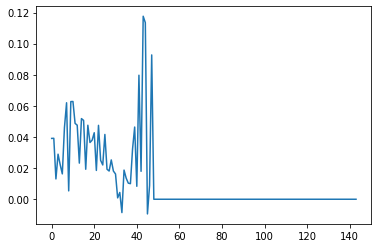

In [190]:
# rs2
# k0 = [1.1]
# lb = [0.9]
# ub = [1.2]
# k0 = [1.5, 1.105]
# lb = [0.5, 0.9]
# ub = [3, 1.2]

# Beads
k0 = [100e-6]
lb = [1e-9]
ub = [1e-3]

# fit of quantum yield trans to cis anionic
# k0 = [0.02]
# lb = [1e-4]
# ub = [5e-1]
# k0 = [0.02, 1e-3]
# lb = [1e-4, 1e-6]
# ub = [5e-1, 1e-1]
# k0 = [0.02, 1e-3, 50e-6]
# lb = [1e-4, 1e-6, 1e-6]
# ub = [5e-1, 1e-1, 500e-6]


plt.plot(residuals(k0))
fitout = least_squares(residuals, k0, bounds=(lb,ub))

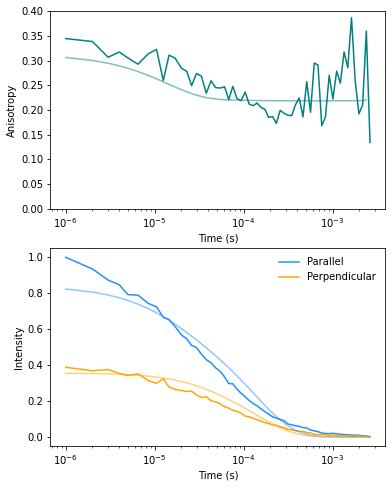

In [191]:
k = fitout['x']
r_theo, il_theo, ip_theo = fitting_model(k, system, t, il, ip)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=False)
fig.set_figheight(8)
fig.set_figwidth(6)
plt.axes(axs[0])
plt.plot(t, r, color='teal')
plt.plot(t, r_theo, color='teal', alpha=0.5)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Anisotropy')
plt.ylim([0, 0.4])

plt.axes(axs[1])
plt.plot(t, il, color='dodgerblue')
plt.plot(t, ip, color='orange')
plt.plot(t, il_theo, color='dodgerblue', alpha=0.5)
plt.plot(t, ip_theo, color='orange', alpha=0.5)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(('Parallel', 'Perpendicular'), frameon=False)

plt.savefig('anisotropy_fit'+fit_index+'_'+sample_name,dpi=300)

In [192]:
mdict = {
    'fit_output': fitout,
    't': t,
    'r': r,
    'il': il,
    'ip': ip,
    'r_theo': r_theo,
    'il_theo': il_theo,
    'ip_theo': ip_theo,
    'bias': bias,
    'k0': k0,
    'lb': lb,
    'ub': ub,
    't_max': t_max,
}

sio.savemat('fit'+fit_index+'data_'+sample_name+'.mat', mdict)

In [193]:
k

array([6.04127381e-05])